In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#ACTIVE ADDRESSES
active_addresses = pd.read_csv("data/bitcoin-number-of-active-addresses.csv")

active_addresses["Active Addresses/t"] = active_addresses["Active Addresses/t"].str.rstrip("T00:00:00.000Z")
active_addresses["Active Addresses/t"] = pd.to_datetime(active_addresses["Active Addresses/t"])
active_addresses = active_addresses.sort_values(by='Active Addresses/t')
active_addresses = active_addresses.rename(columns={'Active Addresses/t': 'Timestamp', 'Active Addresses/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
active_addresses = active_addresses[~(active_addresses['Timestamp'] < '2010-01-01')]
active_addresses = active_addresses[~(active_addresses['Timestamp'] > '2021-12-31')]

#fixing index
active_addresses.reset_index(drop=True, inplace=True)

#Description
print(active_addresses.head())
print("\nShape is:", active_addresses.shape)
print("\nSummary of the dataset:")
active_addresses.describe()
print("\nAre there null values?")
active_addresses.isna().sum()

# Extract years
active_addresses['year'] = [d.year for d in active_addresses["Timestamp"]]

active_addresses.year.unique()


   Timestamp  Value
0 2010-01-04     85
1 2010-01-11    241
2 2010-01-18     24
3 2010-01-25    191
4 2010-02-01    383

Shape is: (626, 2)

Summary of the dataset:

Are there null values?


array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021])

# VISUALIZATION

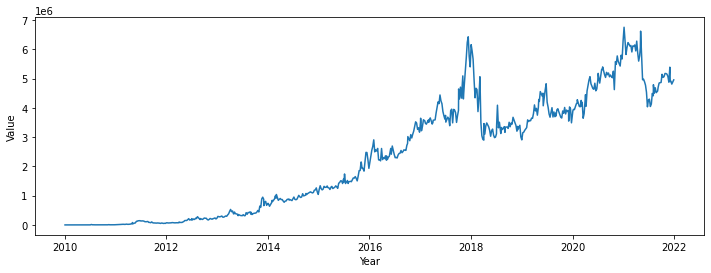

In [3]:
plt.figure(figsize=(12,4))
plt.plot(active_addresses["Timestamp"], active_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

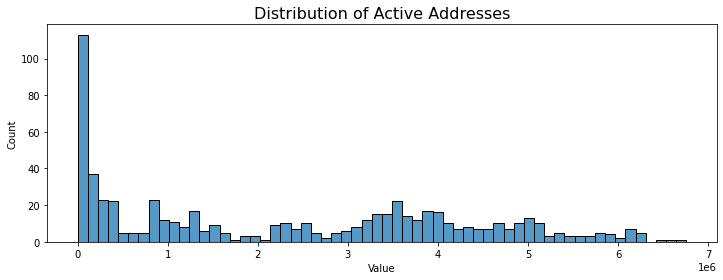

In [4]:
plt.figure(figsize=(12,4))
sns.histplot(active_addresses["Value"], kde = False, bins = 60)
plt.title('Distribution of Active Addresses', fontsize=16)
plt.show()

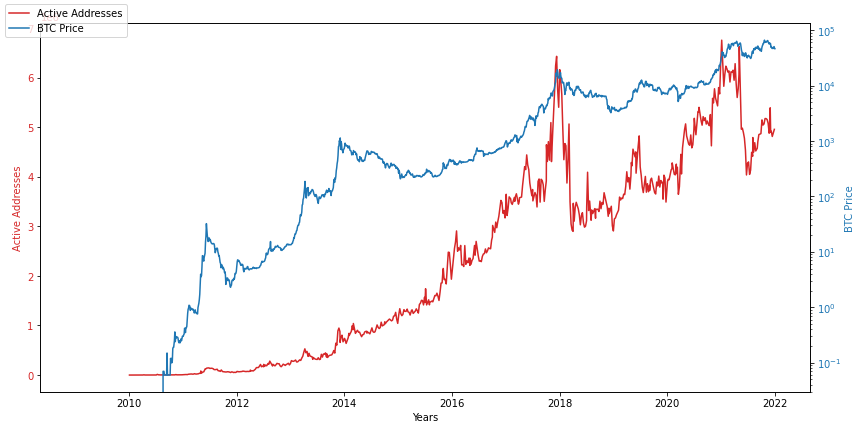

In [5]:
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Active Addresses', color=color)
ax1.plot(active_addresses["Timestamp"], active_addresses["Value"], color=color, label='Active Addresses')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Shorter time series
Same as market price

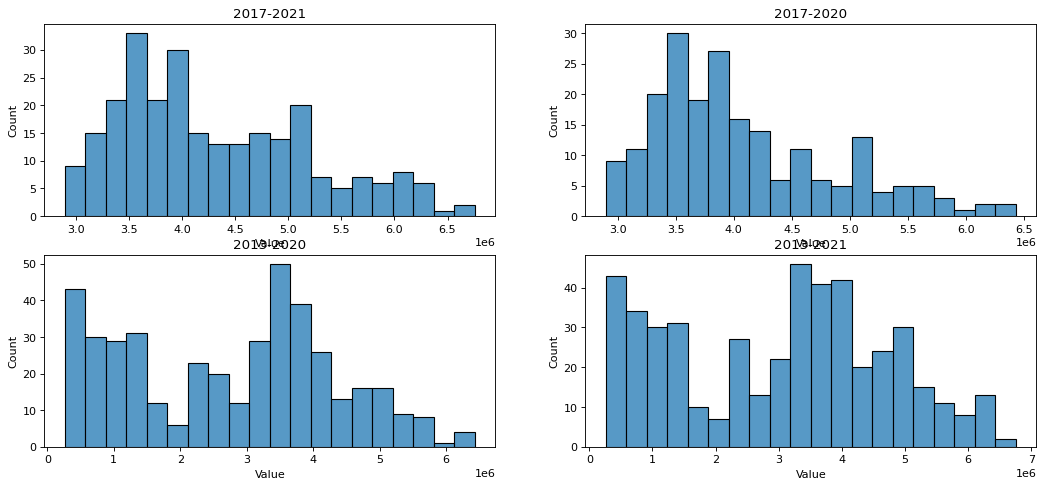

In [6]:
activeh = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2016) & (active_addresses["Timestamp"].dt.year < 2022),:]
activen = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2016) & (active_addresses["Timestamp"].dt.year < 2021),:]
activenh = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2012) & (active_addresses["Timestamp"].dt.year < 2021),:]
activef = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2012) & (active_addresses["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(16,7), dpi= 80)
sns.histplot(activeh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(activen["Value"], ax=axes[0,1],bins = 20)
sns.histplot(activenh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(activef["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

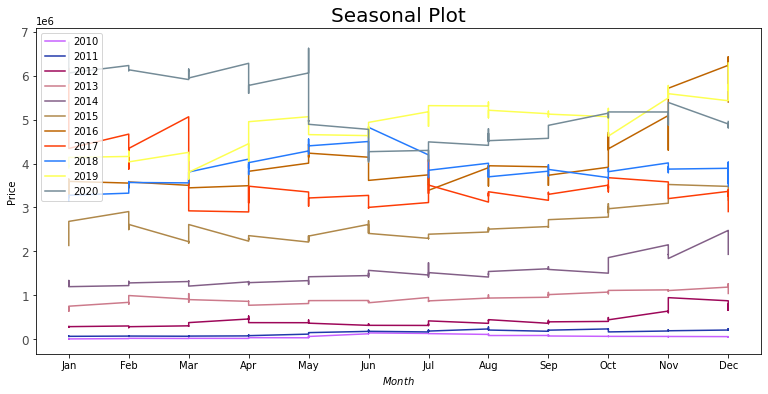

In [7]:
# Prepare data
active_addresses['year'] = [d.year for d in active_addresses["Timestamp"]]
active_addresses['month'] = [d.strftime('%b') for d in active_addresses["Timestamp"]]
years = active_addresses['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(13,6))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=active_addresses.loc[active_addresses.year==y, :], color=mycolors[i], label=y)
# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

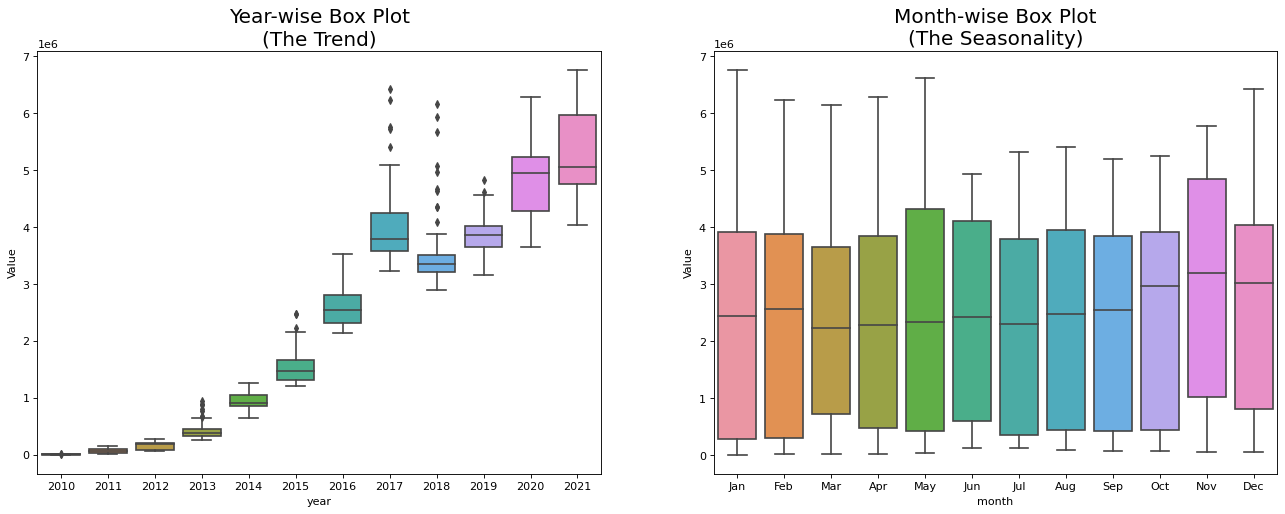

In [8]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=active_addresses, ax=axes[0])
sns.boxplot(x='month', y="Value", data=active_addresses.loc[~active_addresses.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Sesonal analysis

We use STL and compare robust = True and False


Text(0.5, 0.98, 'ACTIVE ADDRESSES / 2010-2021 ')

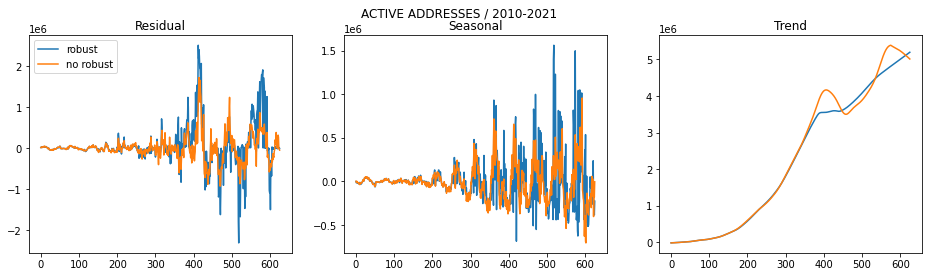

In [9]:
res1 = STL(active_addresses["Value"], period = 52, robust = True).fit()
res2 = STL(active_addresses["Value"], period = 52).fit()

fig, axs = plt.subplots(ncols=3, figsize=(16,4))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('ACTIVE ADDRESSES / 2010-2021 ')

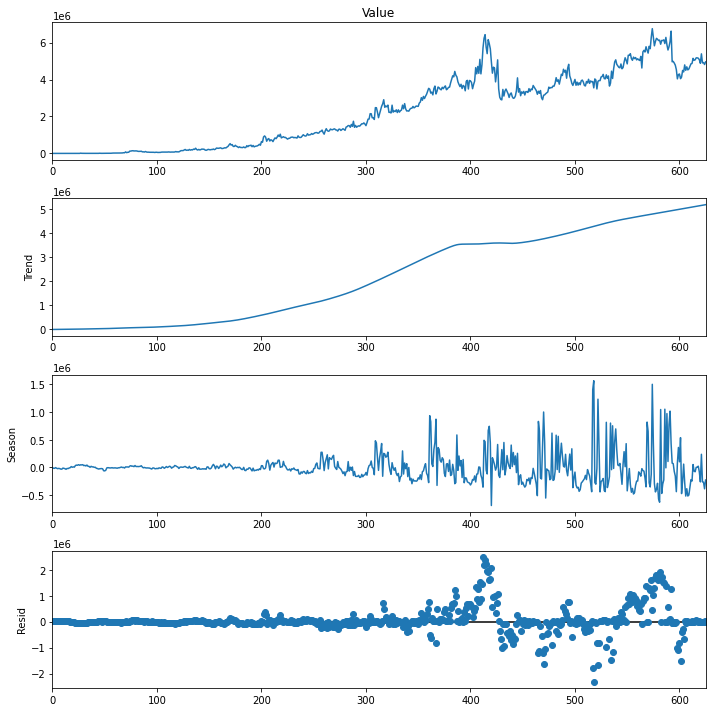

In [10]:
plt.rc("figure", figsize=(10, 10))
fig = res1.plot() #BIGGER VIEW

Since we see that the plot with the logarithmic scale is quite regular (below) we repeat the decomposition analysis after log-transforming the time series


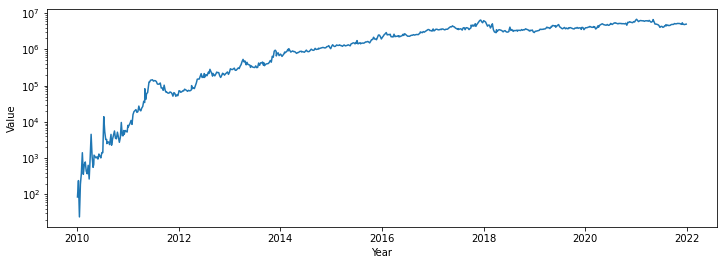

In [11]:
plt.figure(figsize=(12,4))
plt.plot(active_addresses["Timestamp"], active_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
plt.yscale('log') 
plt.show()

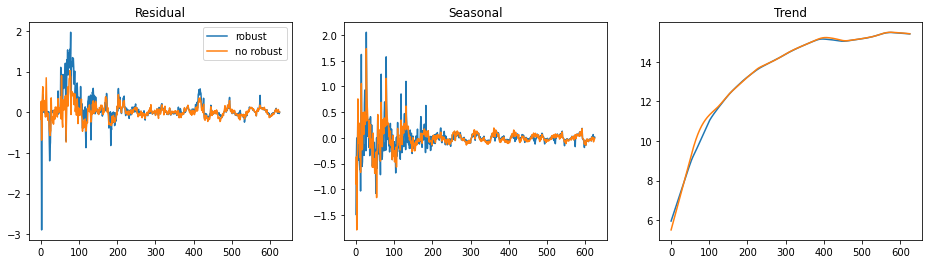

In [12]:
res3 = STL(np.log(active_addresses["Value"]), period = 52, robust = True).fit()
res4 = STL(np.log(active_addresses["Value"]), period = 52).fit()
fig, axs = plt.subplots(ncols=3, figsize=(16,4))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')

# TRAIN/VAL/TEST SPLIT

In [13]:
series = active_addresses['Value']

# Create train data set
train_split_date = '2018-02-26'
train_split_index = np.where(active_addresses.Timestamp == train_split_date)[0][0]
x_train = active_addresses.loc[active_addresses['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2020-01-27'
test_split_index = np.where(active_addresses.Timestamp == test_split_date)[0][0]
x_test = active_addresses.loc[active_addresses['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = active_addresses.loc[(active_addresses['Timestamp'] < test_split_date) & (active_addresses['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-04 to 2018-02-26 00:00:00 - Number of days = 426
Validation set ranging from 2018-03-05 00:00:00 to 2020-01-13 00:00:00 - Number of days = 99
Test set ranging from 2020-01-27 00:00:00 to 2021-12-27 00:00:00 - Number of days = 101


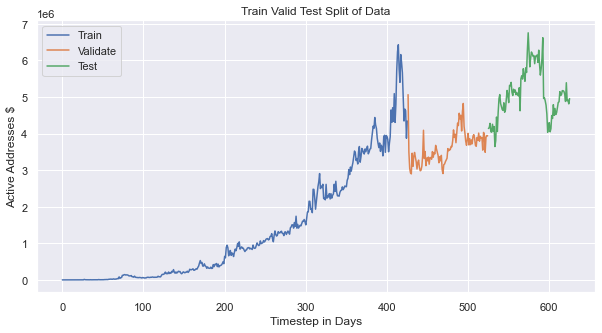

In [14]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Active Addresses $')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-04 to", active_addresses.iloc[425]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", active_addresses.iloc[x_valid.index.min()]["Timestamp"], "to", active_addresses.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", active_addresses.iloc[x_test.index.min()]["Timestamp"], "to", active_addresses.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [15]:
len(x_train.index)

426

In [16]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


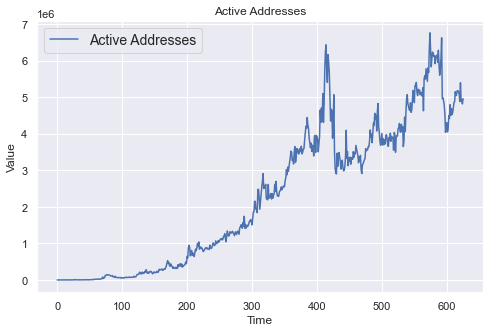

In [17]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(label)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=active_addresses.index,series=active_addresses['Value'], label = 'Active Addresses')

In [18]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Active Addresses Forecast vs Actual')

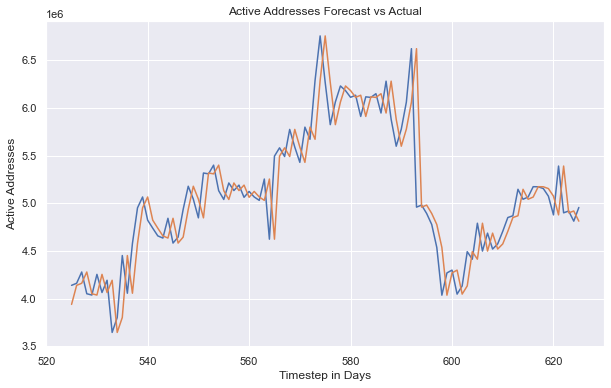

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('Active Addresses Forecast vs Actual')

## Calculate Error in Naive Model

In [20]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 224349.71287128713}

In [21]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[3940105 4140031 4161786]
[4140031 4161786 4279917]
****************************************************************************************************
[199926  21755 118131]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

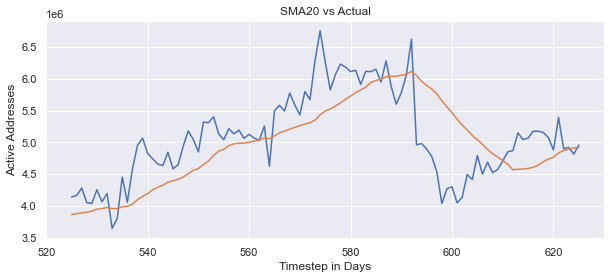

In [22]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = active_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index:]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [23]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 224349.71287128713, 'SMA 20': 437593.80198019807}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

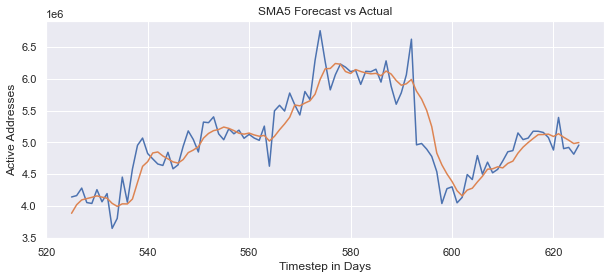

In [24]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = active_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index: ]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [25]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

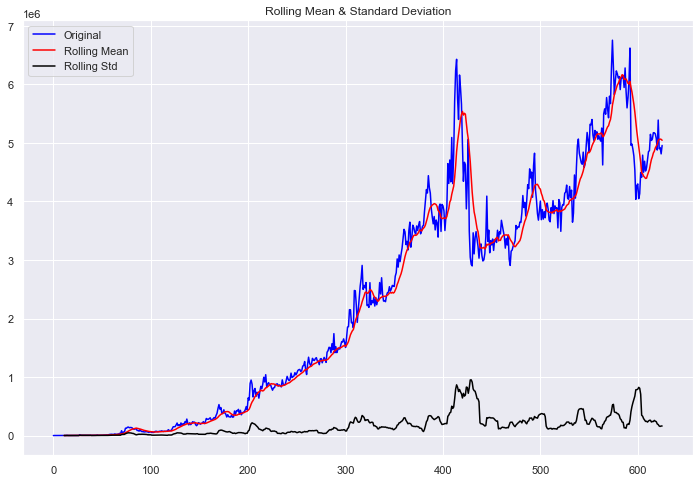

Results of Dickey-Fuller Test:
p-value = 0.8497. The series is likely non-stationary.
Test Statistic                  -0.688653
p-value                          0.849667
#Lags Used                      17.000000
Number of Observations Used    608.000000
Critical Value (1%)             -3.441151
Critical Value (5%)             -2.866305
Critical Value (10%)            -2.569308
dtype: float64


In [26]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

However, it seems, graphically, that the series is not stationary. 

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [27]:
# Get the difference of each Adj Close point
active_addresses_diff_1 = series.diff()
primo = series[0]

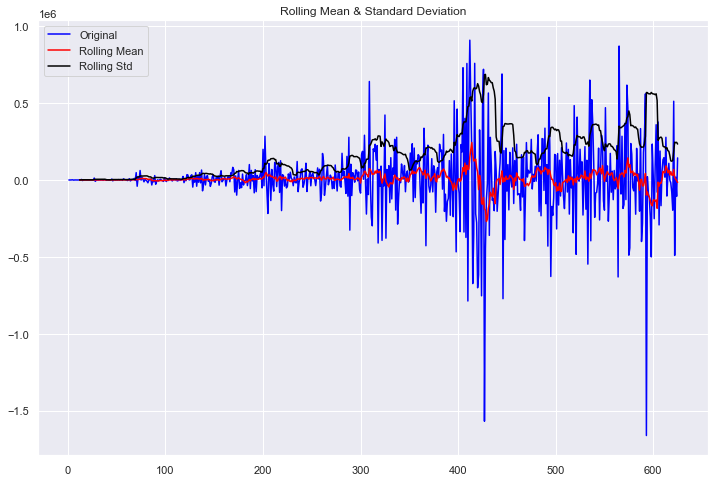

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.635426e+00
p-value                        1.958239e-11
#Lags Used                     1.600000e+01
Number of Observations Used    6.080000e+02
Critical Value (1%)           -3.441151e+00
Critical Value (5%)           -2.866305e+00
Critical Value (10%)          -2.569308e+00
dtype: float64


In [28]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(active_addresses_diff_1.dropna())

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

/usr/local/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


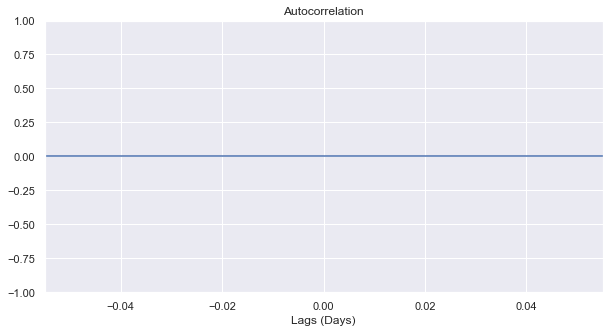

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(active_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

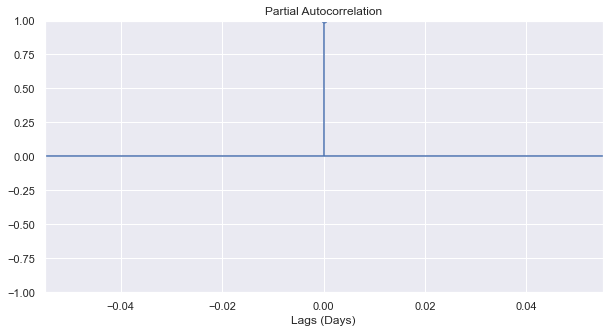

In [30]:
plot_pacf(active_addresses_diff_1, method='ywm')
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

SINCE THE DIFF SERIES IS THE ONLY STATIONARY ONE WE USE IT TO BUILD AND TRAIN THE MODELS. WE WILL RECONSTRUCT THE ORIGINAL SERIES REVERSEING THE DIFFERENCIATION.

We now split the diff series in train, test and validation

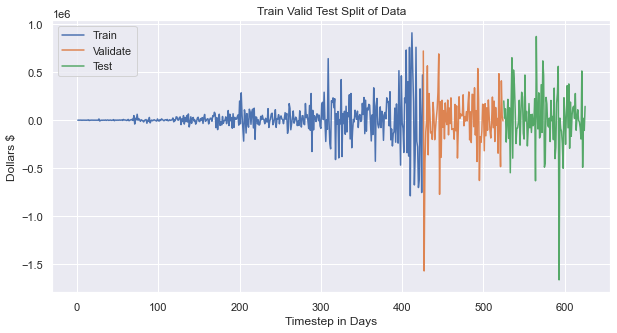

In [31]:
# Create train data set

x_train_diff = active_addresses_diff_1.loc[active_addresses['Timestamp'] <= train_split_date]

# Create test data set
x_test_diff = active_addresses_diff_1.loc[active_addresses['Timestamp'] >= test_split_date]

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid_diff = active_addresses_diff_1.loc[(active_addresses['Timestamp'] < test_split_date) & 
                           (active_addresses['Timestamp'] > train_split_date)]

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train_diff, label = 'Train')
plt.plot(x_valid_diff, label = 'Validate')
plt.plot(x_test_diff, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

### Testing different arima models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=11391.875, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11429.271, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11388.286, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11390.464, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11428.871, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11416.076, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=11390.073, Time=0.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=11390.216, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=11391.291, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=11391.457, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=11394.428, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=11389.611, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=11387.351, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=

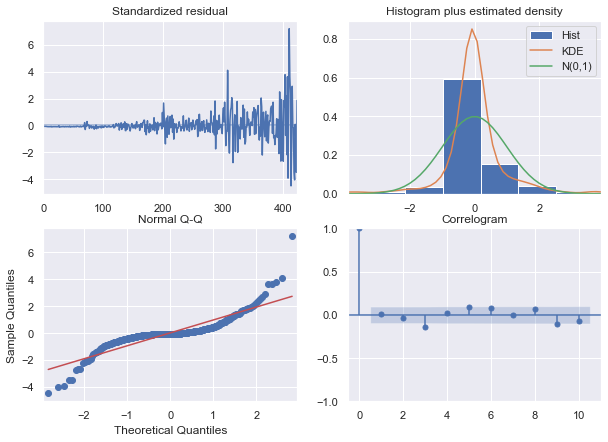

In [32]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(3,2,0)(0,0,1)[7]

In [33]:
import statsmodels.api as sm

# fit model
active_addresses_arima = sm.tsa.arima.ARIMA(x_train, order=(0,1,1), seasonal_order=(1,0,0,7))
active_addresses_arima_fit = active_addresses_arima.fit()
print(active_addresses_arima_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Value   No. Observations:                  426
Model:             ARIMA(0, 1, 1)x(1, 0, [], 7)   Log Likelihood               -5691.891
Date:                          Thu, 10 Nov 2022   AIC                          11389.781
Time:                                  21:29:15   BIC                          11401.938
Sample:                                       0   HQIC                         11394.584
                                          - 426                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1431      0.021     -6.771      0.000      -0.184      -0.102
ar.S.L7       -0.2825      0.021    -13.616      0.

NormaltestResult(statistic=133.0283073461604, pvalue=1.2979862483667048e-29)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


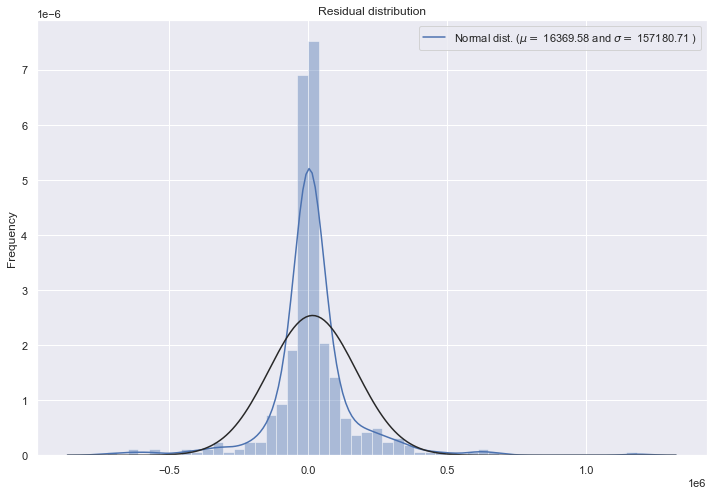

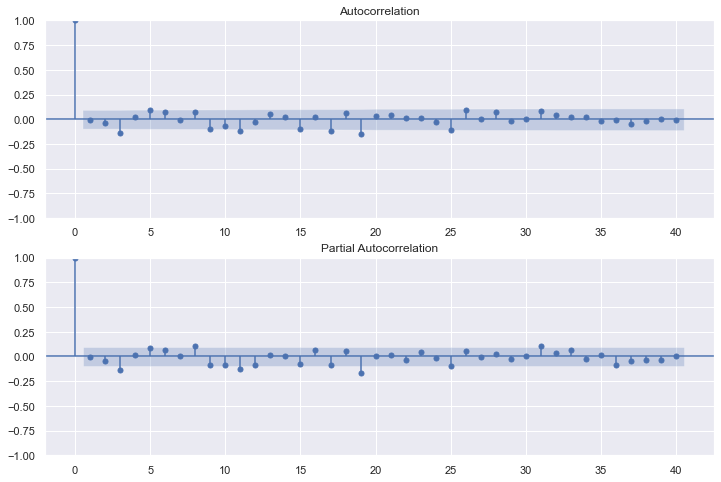

In [34]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = active_addresses_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,3)(0,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [35]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(0,1,1), seasonal_order=(1,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 625173.4351637028
Stored 'model_predictions' (list)


In [36]:
output

array([4659579.54964701])

In [37]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[4376246.367486468,
 4574286.356644896,
 4748611.091608471,
 4656578.257449479,
 4668783.2457306]

In [38]:
model_predictions

[4376246.367486468,
 4574286.356644896,
 4748611.091608471,
 4656578.257449479,
 4668783.2457306,
 4881567.034018374,
 4748524.5473571215,
 4739611.233379648,
 4683670.145111541,
 4634426.342689472,
 4660424.477167063,
 4656976.653410272,
 4596863.015110838,
 4634449.7853410775,
 4636968.1935695745,
 4652773.737872375,
 4666687.566384121,
 4659341.669985028,
 4660315.888356253,
 4677302.632218931,
 4666681.1928932965,
 4665969.460550349,
 4661502.71313838,
 4657570.429999282,
 4659646.539817049,
 4659371.199212405,
 4654570.006385068,
 4657572.163282605,
 4657773.353900112,
 4659035.9778121775,
 4660147.563927145,
 4659560.675122858,
 4659638.51173691,
 4660995.846971086,
 4660147.092571948,
 4660090.20778311,
 4659733.219234718,
 4659418.92339357,
 4659584.86615083,
 4659562.857453458,
 4659179.043198752,
 4659419.051562012,
 4659435.138710684,
 4659536.094052631,
 4659624.979046617,
 4659578.048580616,
 4659584.272996404,
 4659692.827597261,
 4659624.944200271,
 4659620.393756842,
 4

In [39]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_true'] = arima_mae
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

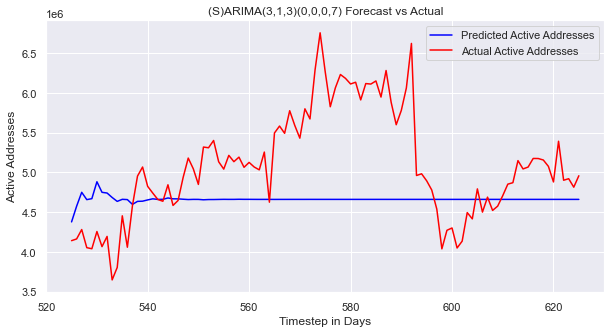

<Figure size 720x432 with 0 Axes>

In [40]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Active Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Active Addresses')
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [41]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

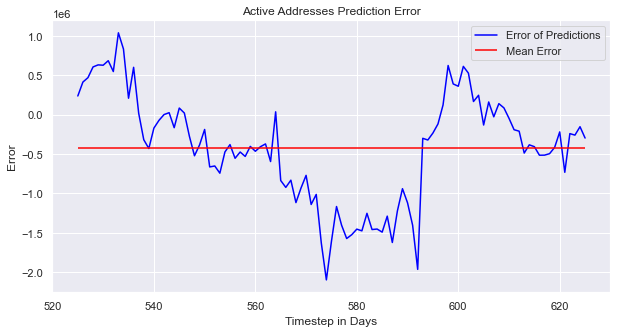

<Figure size 720x432 with 0 Axes>

In [42]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Active Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [43]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028}

### Secondo tipo di ARIMA: training ricorsivo fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

Testing Mean Squared Error is 225045.00546941618
Stored 'model_predictions' (list)


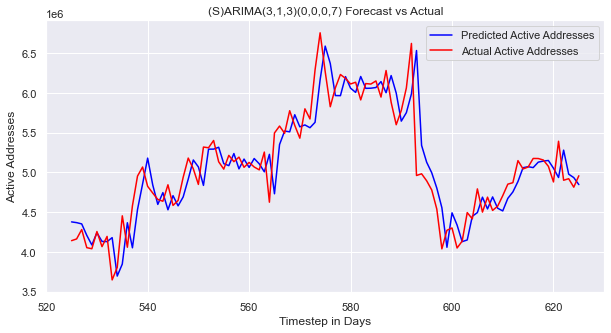

<Figure size 720x432 with 0 Axes>

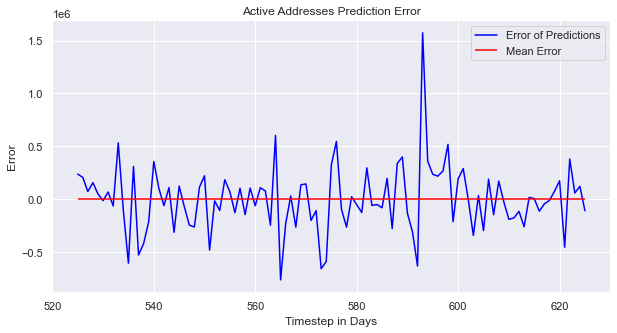

<Figure size 720x432 with 0 Axes>

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028,
 'ARIMA_recursive_fake': 225045.00546941618}

In [44]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point

for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(0,1,1), seasonal_order=(1,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Active Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Active Addresses')
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Active Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione con forecast(185)

Testing Mean Squared Error is 625172.0918592439
Stored 'model_predictions' (ndarray)


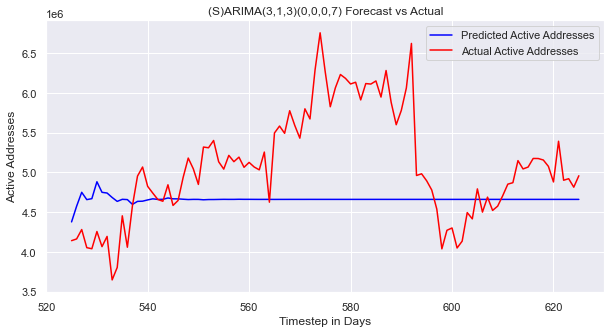

<Figure size 720x432 with 0 Axes>

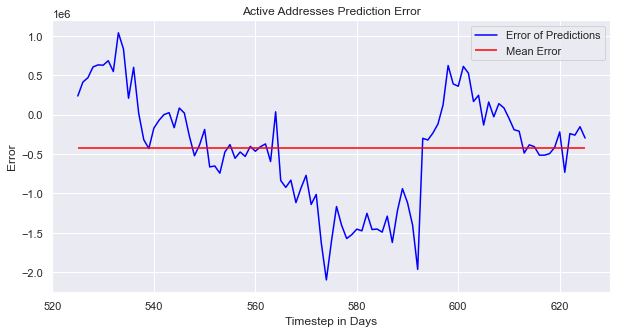

<Figure size 720x432 with 0 Axes>

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028,
 'ARIMA_recursive_fake': 225045.00546941618,
 'ARIMA_forecast': 625172.0918592439}

In [45]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(0,1,1), seasonal_order=(1,0,0,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
#true_test_value = x_test[time_point]
#history.append(true_test_value)
#history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Active Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Active Addresses')
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Active Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

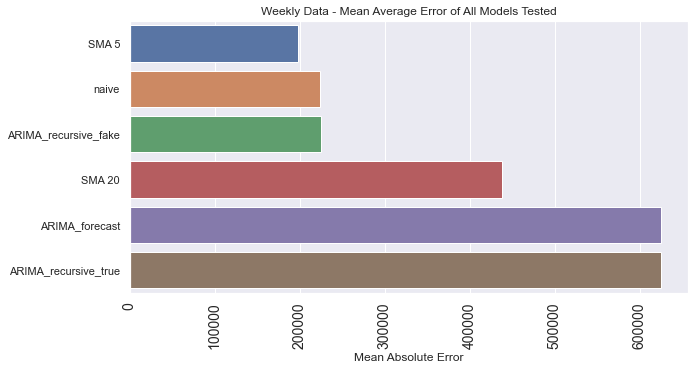

In [46]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [47]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [48]:
x_train

0           85
1          241
2           24
3          191
4          383
        ...   
421    4344355
422    4670210
423    4626997
424    3873673
425    4344692
Name: Value, Length: 426, dtype: int64

In [49]:
x_train.shape

(426,)

In [50]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [51]:
x_train_values

array([[     85],
       [    241],
       [     24],
       [    191],
       [    383],
       [   1413],
       [    358],
       [    669],
       [    784],
       [    438],
       [    371],
       [    636],
       [    266],
       [    978],
       [   4543],
       [   1121],
       [    558],
       [    674],
       [   1210],
       [   1016],
       [   1087],
       [    945],
       [   1299],
       [   1137],
       [   1017],
       [   1423],
       [   1419],
       [  13932],
       [   5337],
       [   3251],
       [   3268],
       [   2515],
       [   2811],
       [   2778],
       [   2365],
       [   4524],
       [   2274],
       [   3336],
       [   5622],
       [   3521],
       [   3425],
       [   5200],
       [   3859],
       [   2737],
       [   3703],
       [   9636],
       [   4179],
       [   4177],
       [   5789],
       [   4546],
       [   5795],
       [   5247],
       [   8021],
       [   7172],
       [   9174],
       [  

In [52]:
x_train_values.shape

(426, 1)

In [53]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

Spiegazione su come funziona: https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it

In [54]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


21/21 [==============================] - 6s 35ms/step - loss: 0.0356 - mae: 0.1757 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0330 - mae: 0.1670 - lr: 1.1220e-05
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0305 - mae: 0.1598 - lr: 1.2589e-05
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 0.0279 - mae: 0.1523 - lr: 1.4125e-05
Epoch 5/100
21/21 [==============================] - 0s 16ms/step - loss: 0.0250 - mae: 0.1440 - lr: 1.5849e-05
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0219 - mae: 0.1347 - lr: 1.7783e-05
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 0.0186 - mae: 0.1246 - lr: 1.9953e-05
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0151 - mae: 0.1134 - lr: 2.2387e-05
Epoch 9/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0114 - mae: 0.1008 - lr: 2.5119e-05
Epoc

(1e-05, 0.1, 0.0, 0.03)

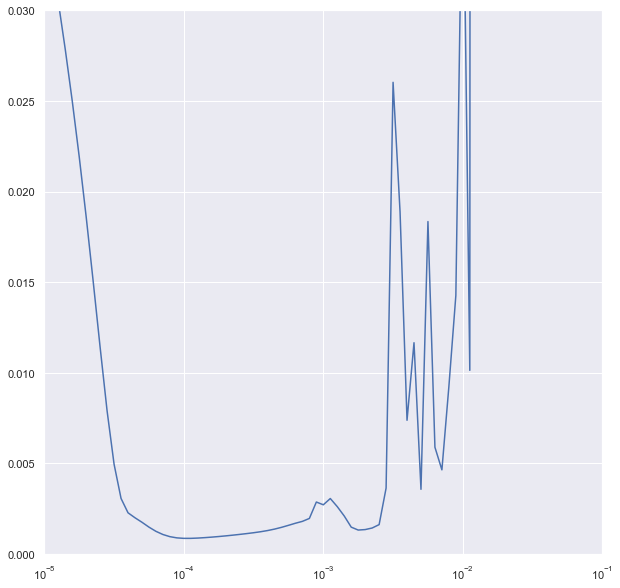

In [55]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [56]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00033

In [57]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     14/Unknown - 5s 18ms/step - loss: 0.0224 - mae: 0.1427   

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


14/14 [==============================] - 26s 2s/step - loss: 0.0224 - mae: 0.1427 - val_loss: 0.0484 - val_mae: 0.3042
Epoch 2/500
11/14 [======================>.......] - ETA: 0s - loss: 0.0025 - mae: 0.0521    

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


14/14 [==============================] - 20s 2s/step - loss: 0.0108 - mae: 0.0990 - val_loss: 0.0166 - val_mae: 0.1688
Epoch 3/500
14/14 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0690

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


14/14 [==============================] - 20s 2s/step - loss: 0.0044 - mae: 0.0690 - val_loss: 0.0034 - val_mae: 0.0643
Epoch 4/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0025 - mae: 0.0584 - val_loss: 0.0067 - val_mae: 0.0894
Epoch 5/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0022 - mae: 0.0584 - val_loss: 0.0099 - val_mae: 0.1124
Epoch 6/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0017 - mae: 0.0500 - val_loss: 0.0112 - val_mae: 0.1201
Epoch 7/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0413 - val_loss: 0.0125 - val_mae: 0.1273
Epoch 8/500
14/14 [==============================] - 0s 22ms/step - loss: 9.6886e-04 - mae: 0.0345 - val_loss: 0.0136 - val_mae: 0.1330
Epoch 9/500
14/14 [==============================] - 0s 20ms/step - loss: 8.2722e-04 - mae: 0.0294 - val_loss: 0.0143 - val_mae: 0.1364
Epoch 10/500
14/14 [==============================] - 0s 20ms/step - loss: 7.6082

### Make predictions

In [58]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
#rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
#rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 19ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 19ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

(101,)

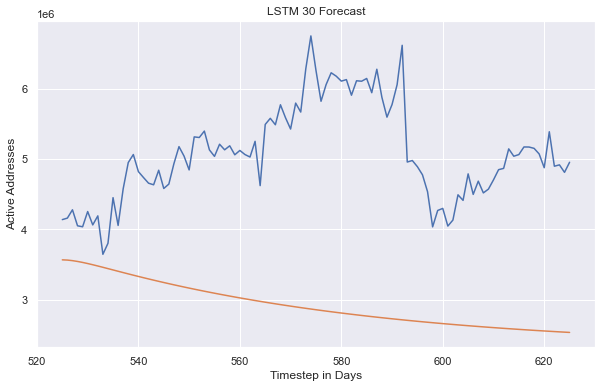

In [59]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [60]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_iterative'] = lstm
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028,
 'ARIMA_recursive_fake': 225045.00546941618,
 'ARIMA_forecast': 625172.0918592439,
 'LSTM_iterative': 2146443.5693069305}

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

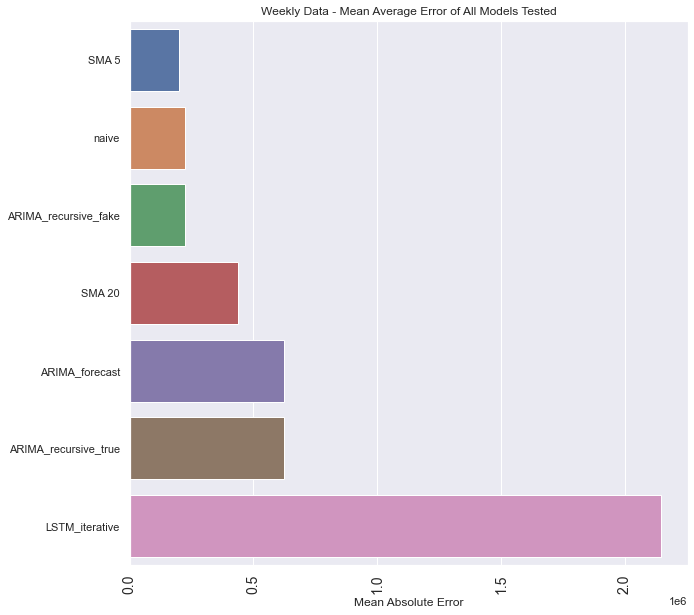

In [61]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')

1/1 [==============================] - 1s 990ms/step


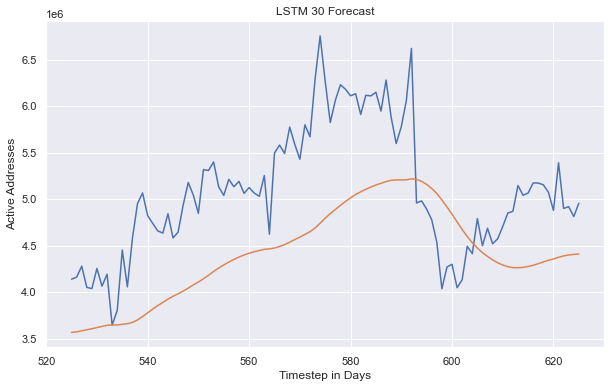

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

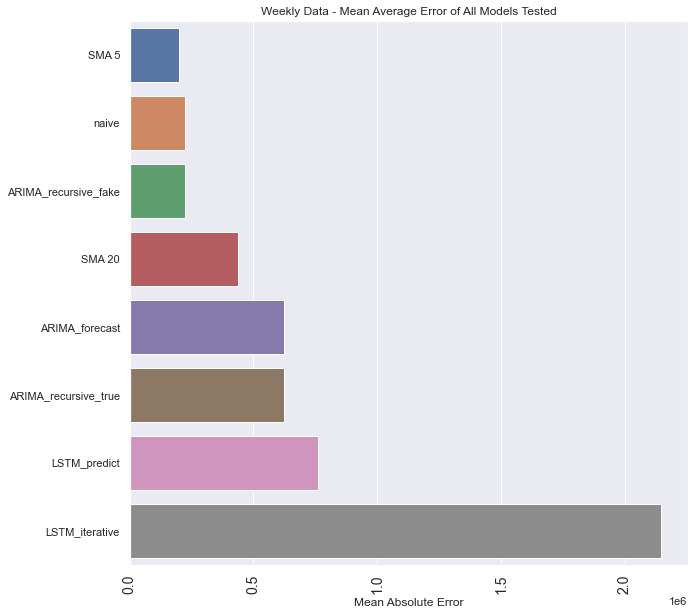

In [62]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_predict'] = lstm
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [63]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [64]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 3s 28ms/step - loss: 0.0416 - mae: 0.1928 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0410 - mae: 0.1907 - lr: 1.0798e-04
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0403 - mae: 0.1883 - lr: 1.1659e-04
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0394 - mae: 0.1853 - lr: 1.2589e-04
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0384 - mae: 0.1821 - lr: 1.3594e-04
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0371 - mae: 0.1784 - lr: 1.4678e-04
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0355 - mae: 0.1744 - lr: 1.5849e-04
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0337 - mae: 0.1703 - lr: 1.7113e-04
Epoch 9/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0316 - mae: 0.1654 - lr: 1.8478e-04
Epoch 10/100
4/4 [====

Epoch 76/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0107 - mae: 0.1199 - lr: 0.0316
Epoch 77/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0340 - mae: 0.1789 - lr: 0.0341
Epoch 78/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0237 - mae: 0.1692 - lr: 0.0369
Epoch 79/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0232 - mae: 0.1768 - lr: 0.0398
Epoch 80/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0232 - mae: 0.1774 - lr: 0.0430
Epoch 81/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0232 - mae: 0.1749 - lr: 0.0464
Epoch 82/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0232 - mae: 0.1748 - lr: 0.0501
Epoch 83/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0233 - mae: 0.1727 - lr: 0.0541
Epoch 84/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0235 - mae: 0.1769 - lr: 0.0584
Epoch 85/100
4/4 [===================

(0.0001, 0.1, 0.0, 0.04)

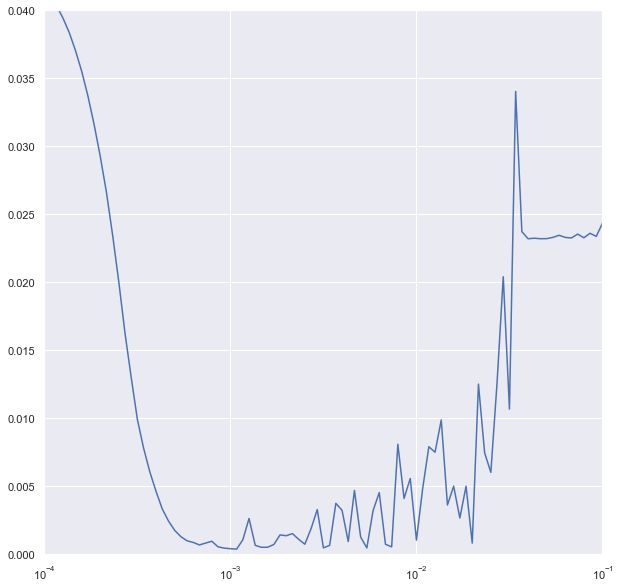

In [65]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [66]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00027

In [67]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
4/4 [==============================] - 4s 327ms/step - loss: 0.0357 - mae: 0.1780 - val_loss: 0.0946 - val_mae: 0.4299
Epoch 2/500
4/4 [==============================] - 0s 108ms/step - loss: 0.0146 - mae: 0.1218 - val_loss: 0.0210 - val_mae: 0.1764
Epoch 3/500
4/4 [==============================] - 1s 123ms/step - loss: 0.0059 - mae: 0.0858 - val_loss: 0.0096 - val_mae: 0.1007
Epoch 4/500
4/4 [==============================] - 0s 96ms/step - loss: 0.0025 - mae: 0.0495 - val_loss: 0.0440 - val_mae: 0.2916
Epoch 5/500
4/4 [==============================] - 0s 110ms/step - loss: 0.0054 - mae: 0.0645 - val_loss: 0.0033 - val_mae: 0.0602
Epoch 6/500
4/4 [==============================] - 0s 97ms/step - loss: 7.1456e-04 - mae: 0.0251 - val_loss: 0.0045 - val_mae: 0.0849
Epoch 7/500
4/4 [==============================] - 0s 95ms/step - loss: 9.7751e-04 - mae: 0.0315 - val_loss: 0.0041 - val_mae: 0.0809
Epoch 8/500
4/4 [==============================] - 0s 110ms/step - loss: 7.831

4/4 [==============================] - 0s 100ms/step - loss: 2.0533e-04 - mae: 0.0116 - val_loss: 8.1069e-04 - val_mae: 0.0307
Epoch 121/500
4/4 [==============================] - 0s 100ms/step - loss: 2.1228e-04 - mae: 0.0121 - val_loss: 9.1410e-04 - val_mae: 0.0328
Epoch 122/500
4/4 [==============================] - 0s 100ms/step - loss: 2.4078e-04 - mae: 0.0133 - val_loss: 0.0012 - val_mae: 0.0390
Epoch 123/500
4/4 [==============================] - 0s 100ms/step - loss: 3.1473e-04 - mae: 0.0154 - val_loss: 0.0077 - val_mae: 0.1175
Epoch 124/500
4/4 [==============================] - 0s 96ms/step - loss: 0.0020 - mae: 0.0427 - val_loss: 0.0013 - val_mae: 0.0420
Epoch 125/500
4/4 [==============================] - 0s 98ms/step - loss: 3.4635e-04 - mae: 0.0171 - val_loss: 6.7436e-04 - val_mae: 0.0278
Epoch 126/500
4/4 [==============================] - 1s 116ms/step - loss: 2.1431e-04 - mae: 0.0127 - val_loss: 6.5878e-04 - val_mae: 0.0278
Epoch 127/500
4/4 [==========================

In [68]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 30ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

(101,)

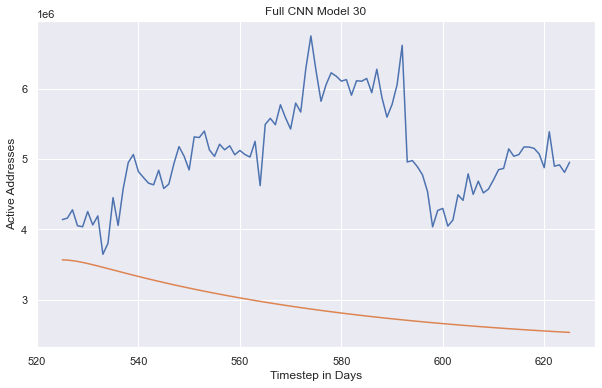

In [69]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

In [70]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_iterative'] = cnn
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 437593.80198019807,
 'SMA 5': 197612.95247524747,
 'ARIMA_recursive_true': 625173.4351637028,
 'ARIMA_recursive_fake': 225045.00546941618,
 'ARIMA_forecast': 625172.0918592439,
 'LSTM_iterative': 2146443.5693069305,
 'LSTM_predict': 761671.7747524752,
 'CNN_iterative': 2146443.5693069305}

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

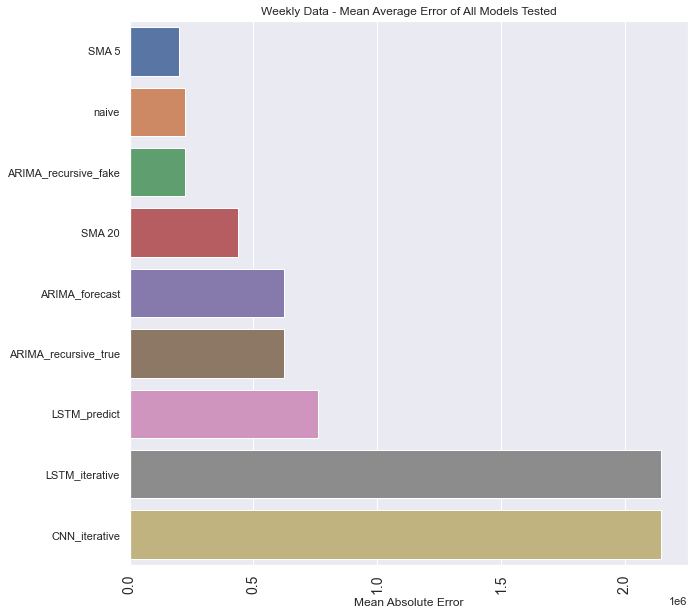

In [71]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')

In [72]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

19/19 [==============================] - 1s 11ms/step


(101,)

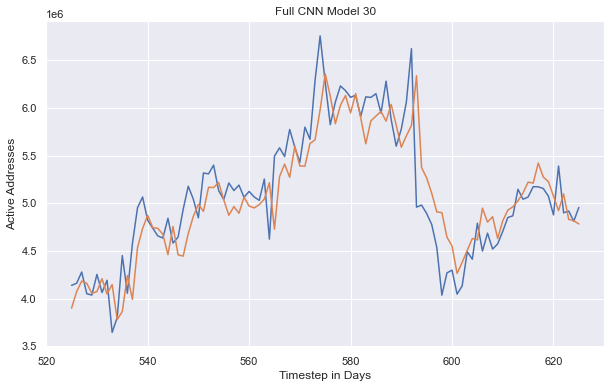

In [73]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

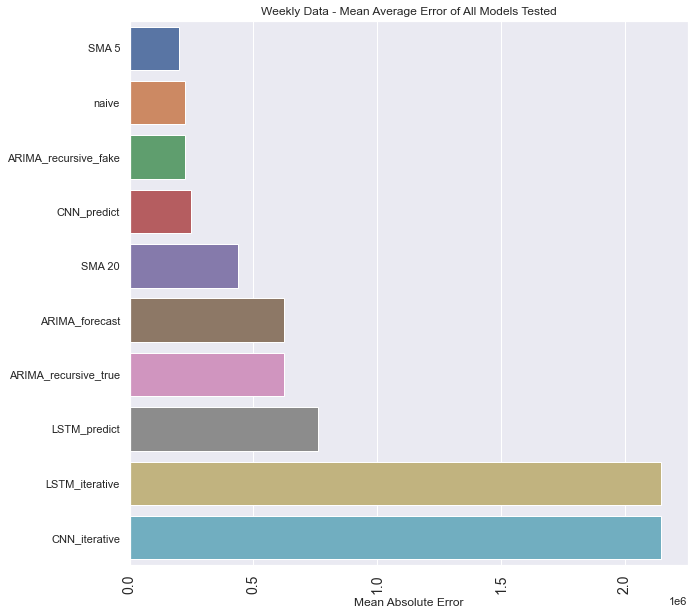

In [74]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_predict'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')